# Environment

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Set the current working directory
os.chdir('/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_MECP2')

# Load Data

In [3]:
DEA_NEU = pd.read_csv("DEA_NEU.csv", header=0)
DEA_NSC = pd.read_csv("DEA_NSC.csv", header=0)

In [4]:
DEA_NEU.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,H2afy2,898.006083,-0.000002,0.096164,-0.000017,0.999986,0.999986
1,Lurap1l,248.853019,0.000021,0.175418,0.000119,0.999905,0.999970
2,Tcea1,1680.603269,0.000090,0.088197,0.001019,0.999187,0.999963
3,Igdcc4,872.289717,0.000126,0.100337,0.001255,0.998999,0.999963
4,Kdm6a,792.508606,-0.000035,0.108607,-0.000325,0.999741,0.999963


In [5]:
DEA_NEU.shape

(12945, 7)

In [6]:
DEA_NEU = DEA_NEU[DEA_NEU['padj'] < 0.05]
DEA_NSC = DEA_NSC[DEA_NSC['padj'] < 0.05]

In [7]:
print(DEA_NEU.shape)
print(DEA_NSC.shape)

(2115, 7)
(8908, 7)


In [8]:
DEA_NEU.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
10830,Etohd2,52.179960,-0.875472,0.325480,-2.689789,0.007150,0.049950
10831,Prepl,6734.833093,-0.182629,0.067887,-2.690180,0.007141,0.049914
10832,Slk,2299.724144,-0.235697,0.087604,-2.690482,0.007135,0.049914
10833,Tomm34,630.507422,-0.309322,0.114977,-2.690304,0.007139,0.049914
10834,Selenon,323.325362,-0.378338,0.140572,-2.691420,0.007115,0.049798


In [9]:
mecp2_NEU = pd.read_csv("allgenes_NEU_total.csv", header=0)
mecp2_NSC = pd.read_csv("allgenes_NSC_total.csv", header=0)

In [10]:
print(mecp2_NEU.shape)
print(mecp2_NSC.shape)

(383, 6)
(3071, 6)


In [11]:
mecp2_NEU.head()

,gene,baseMean,log2FoldChange,Direction,Endogenous_Promoter,Exogenous_Promoter
0,Abcc4,206.795391,-0.595743,DOWN,True,True
1,Abcg2,230.797511,0.825216,UP,False,True
2,Adamts10,501.333702,0.901479,UP,True,True
3,Adamtsl2,252.788651,0.501510,UP,True,True
4,Adgrl2,2101.578603,-1.044162,DOWN,True,True


In [36]:
def volcano_plot(df1, df2, p_value_threshold=0.05, fc_threshold=1, labels=True, promoter_type='Exogenous_Promoter'):
    # Calculate -log10(pvalue) for df1
    df1['neg_log_pvalue'] = -np.log10(df1['padj'])

    # Create a color mapping based on df2
    color_mapping = {}
    for gene in df1['gene']:
        if gene in df2['gene'].values:
            mask = df2['gene'] == gene
            if df2[mask][promoter_type].iloc[0]:
                color_mapping[gene] = 'green'
            else:
                color_mapping[gene] = 'red'
        else:
            color_mapping[gene] = 'lightgrey'

    # Create color list in the same order as df1
    colors = [color_mapping[gene] for gene in df1['gene']]

    plt.figure(figsize=(10, 8))

    # Create scatter plot
    plt.scatter(df1['log2FoldChange'], 
            df1['neg_log_pvalue'],
            c=colors,
            alpha=0.6)

    # Add labels and title
    plt.xlabel('log2 Fold Change', fontsize=12)
    plt.ylabel('-log10(p-value)', fontsize=12)
    plt.title('Volcano Plot of Differential Expression', fontsize=14)

    # Add a grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Create custom legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor='green', label=f'{promoter_type}: True', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor='red', label=f'{promoter_type}: False', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor='lightgrey', label='Not in df2', markersize=10)]

    plt.legend(handles=legend_elements, loc='upper right')

    if labels:
        # Add gene labels for significant genes
        pvalue_threshold = -np.log10(p_value_threshold)
        fc_threshold = fc_threshold 

        for idx, row in df1.iterrows():
            if (abs(row['log2FoldChange']) > fc_threshold) and (row['neg_log_pvalue'] > pvalue_threshold):
                plt.annotate(row['gene'], 
                            (row['log2FoldChange'], row['neg_log_pvalue']),
                            xytext=(5, 5), 
                            textcoords='offset points',
                            fontsize=8)

    plt.tight_layout()

    plt.show()

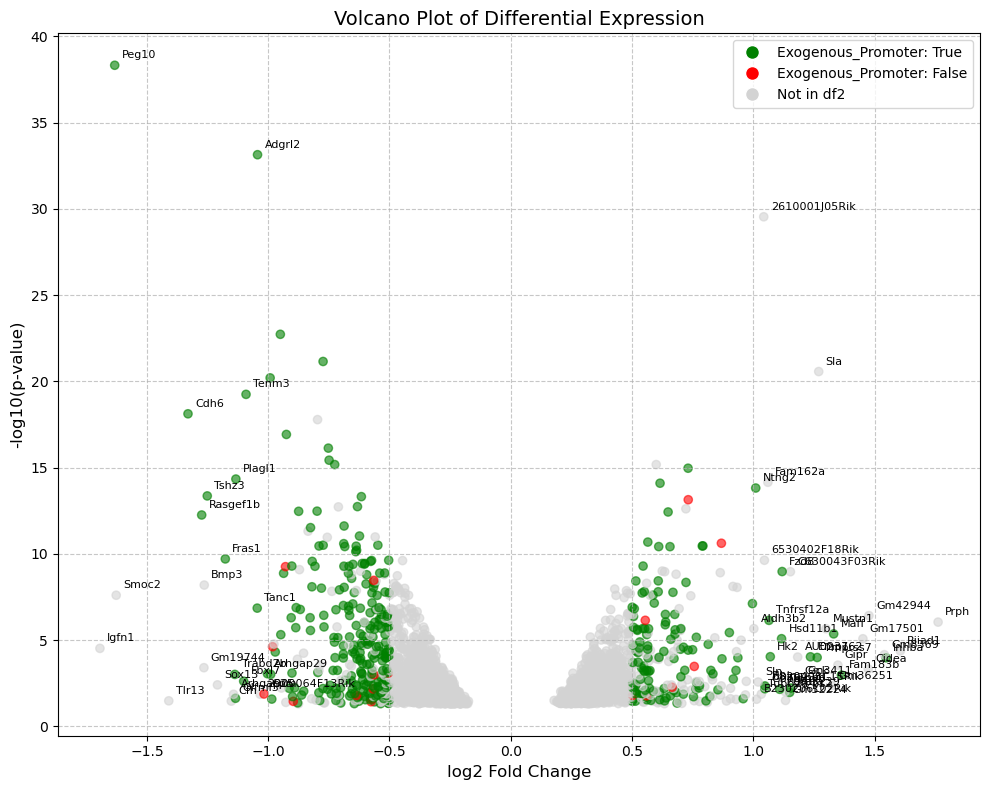

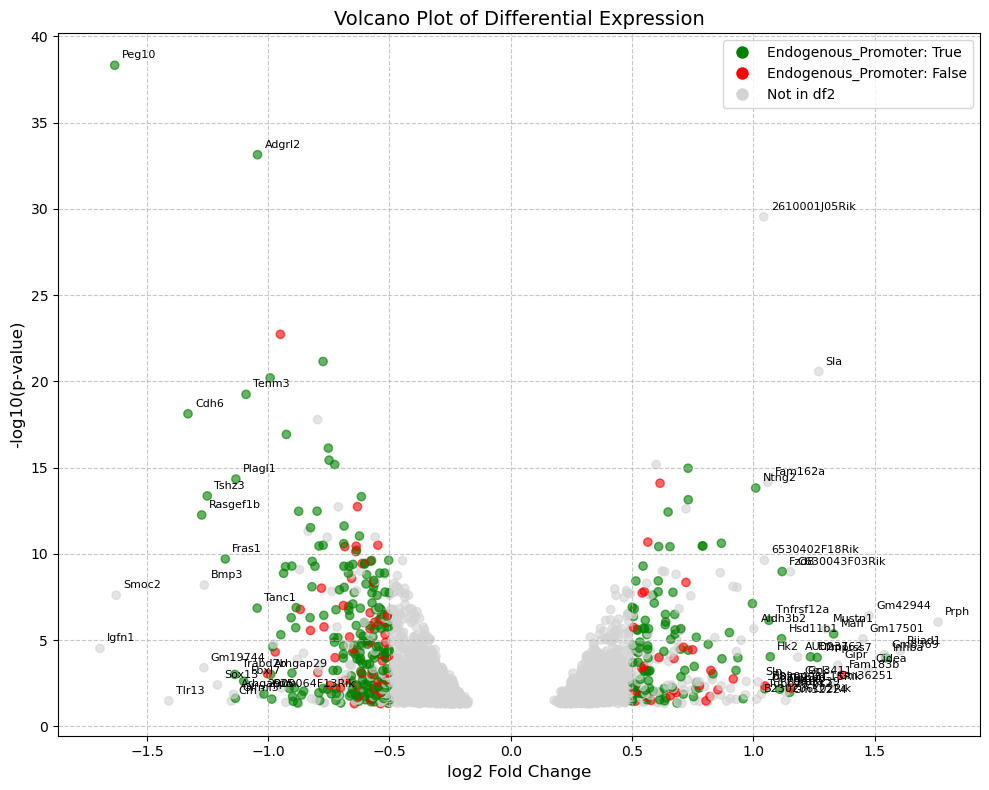

In [37]:
volcano_plot(DEA_NEU, mecp2_NEU, p_value_threshold=0.05, fc_threshold=1, labels=True, promoter_type='Exogenous_Promoter')
volcano_plot(DEA_NEU, mecp2_NEU, p_value_threshold=0.05, fc_threshold=1, labels=True, promoter_type='Endogenous_Promoter')

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


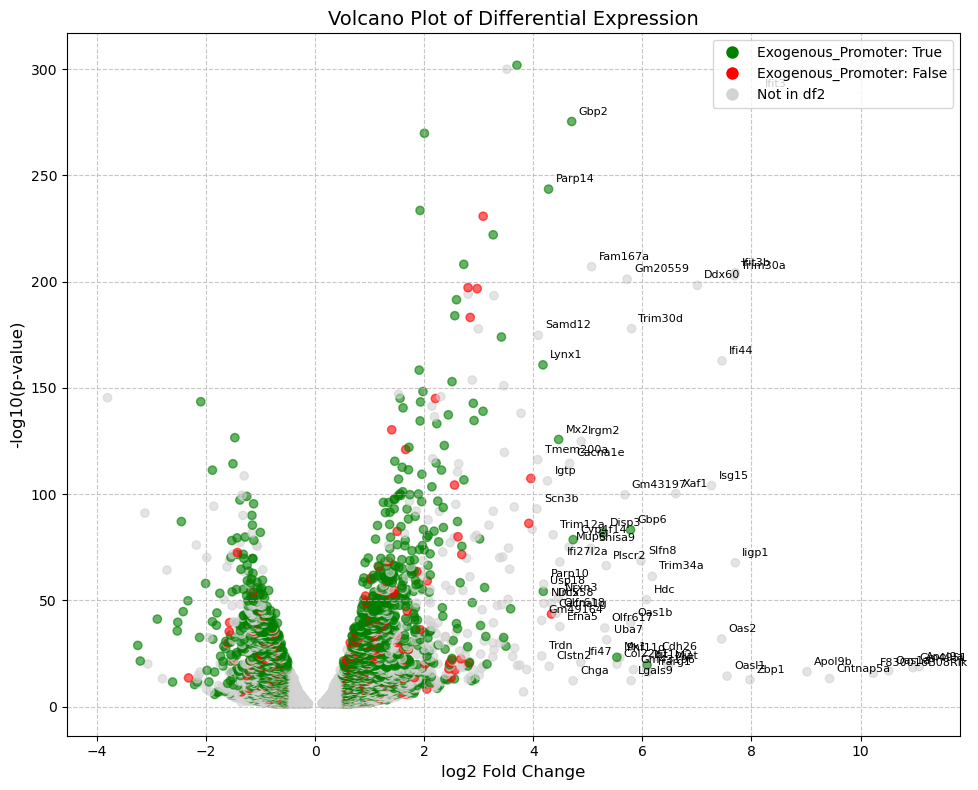

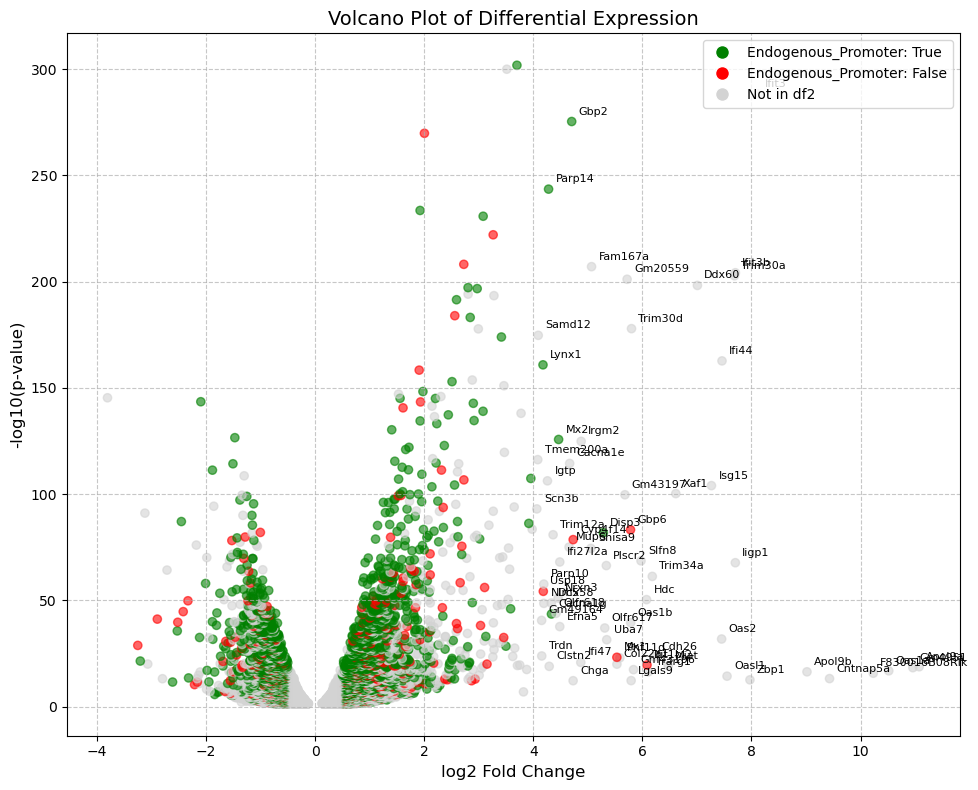

In [39]:
volcano_plot(DEA_NSC, mecp2_NSC, p_value_threshold=0.05, fc_threshold=4, labels=True, promoter_type='Exogenous_Promoter')
volcano_plot(DEA_NSC, mecp2_NSC, p_value_threshold=0.05, fc_threshold=4, labels=True, promoter_type='Endogenous_Promoter')


In [45]:
def volcano_plot_mod(df1, df2, p_value_threshold=0.05, fc_threshold=1, labels=True, promoter_type='Exogenous_Promoter'):
    # Calculate -log10(pvalue) for df1
    df1['neg_log_pvalue'] = -np.log10(df1['padj'])

    # Create a color mapping based on df2
    color_mapping = {}
    for gene in df1['gene']:
        if gene in df2['gene'].values:
            mask = df2['gene'] == gene
            if df2[mask][promoter_type].iloc[0]:
                color_mapping[gene] = 'green'
            else:
                color_mapping[gene] = 'red'
        else:
            color_mapping[gene] = 'lightgrey'

    # Create color list in the same order as df1
    colors = [color_mapping[gene] for gene in df1['gene']]

    return colors, df1['log2FoldChange'], df1['neg_log_pvalue']


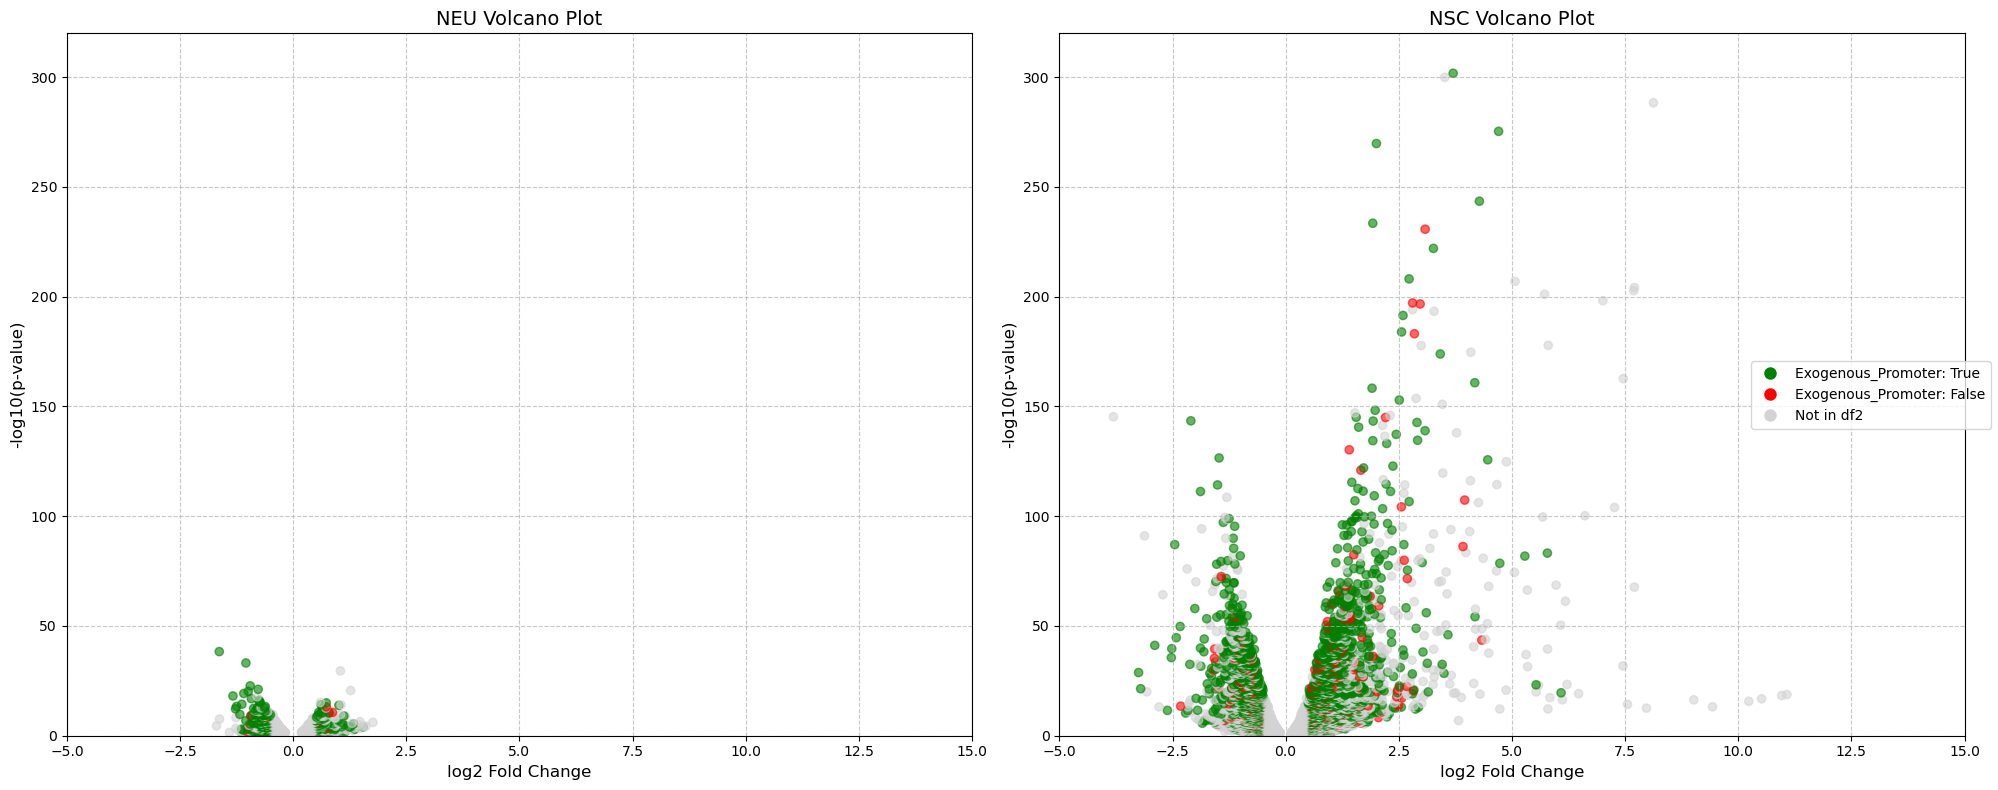

In [48]:
promoter_type='Exogenous_Promoter'

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Get data for both plots
colors1, x1, y1 = volcano_plot_mod(DEA_NEU, mecp2_NEU, promoter_type=promoter_type)
colors2, x2, y2 = volcano_plot_mod(DEA_NSC, mecp2_NSC, promoter_type=promoter_type)

# Find common axis limits
# x_min = min(x1.min(), x2.min())
# x_max = max(x1.max(), x2.max())
# y_min = min(y1.min(), y2.min())
# y_max = max(y1.max(), y2.max())

x_min = -5
x_max = 15
y_min = 0
y_max = 320

# Plot first volcano plot
ax1.scatter(x1, y1, c=colors1, alpha=0.6)
ax1.set_xlabel('log2 Fold Change', fontsize=12)
ax1.set_ylabel('-log10(p-value)', fontsize=12)
ax1.set_title('NEU Volcano Plot', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Add labels for first plot if needed
if True:  # For NEU plot
    pvalue_threshold = -np.log10(0.05)
    fc_threshold = 2
    for x, y, gene in zip(x1, y1, DEA_NEU['gene']):
        if (abs(x) > fc_threshold) and (y > pvalue_threshold):
            ax1.annotate(gene, (x, y), xytext=(5, 5), 
                        textcoords='offset points', fontsize=8)

# Plot second volcano plot
ax2.scatter(x2, y2, c=colors2, alpha=0.6)
ax2.set_xlabel('log2 Fold Change', fontsize=12)
ax2.set_ylabel('-log10(p-value)', fontsize=12)
ax2.set_title('NSC Volcano Plot', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Create custom legend (only need it once since it's the same for both)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='green', label=f'{promoter_type}: True', markersize=10),
                plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='red', label=f'{promoter_type}: False', markersize=10),
                plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='lightgrey', label='Not in df2', markersize=10)]

# Add legend to figure
fig.legend(handles=legend_elements, loc='center right')

plt.tight_layout()
plt.show()

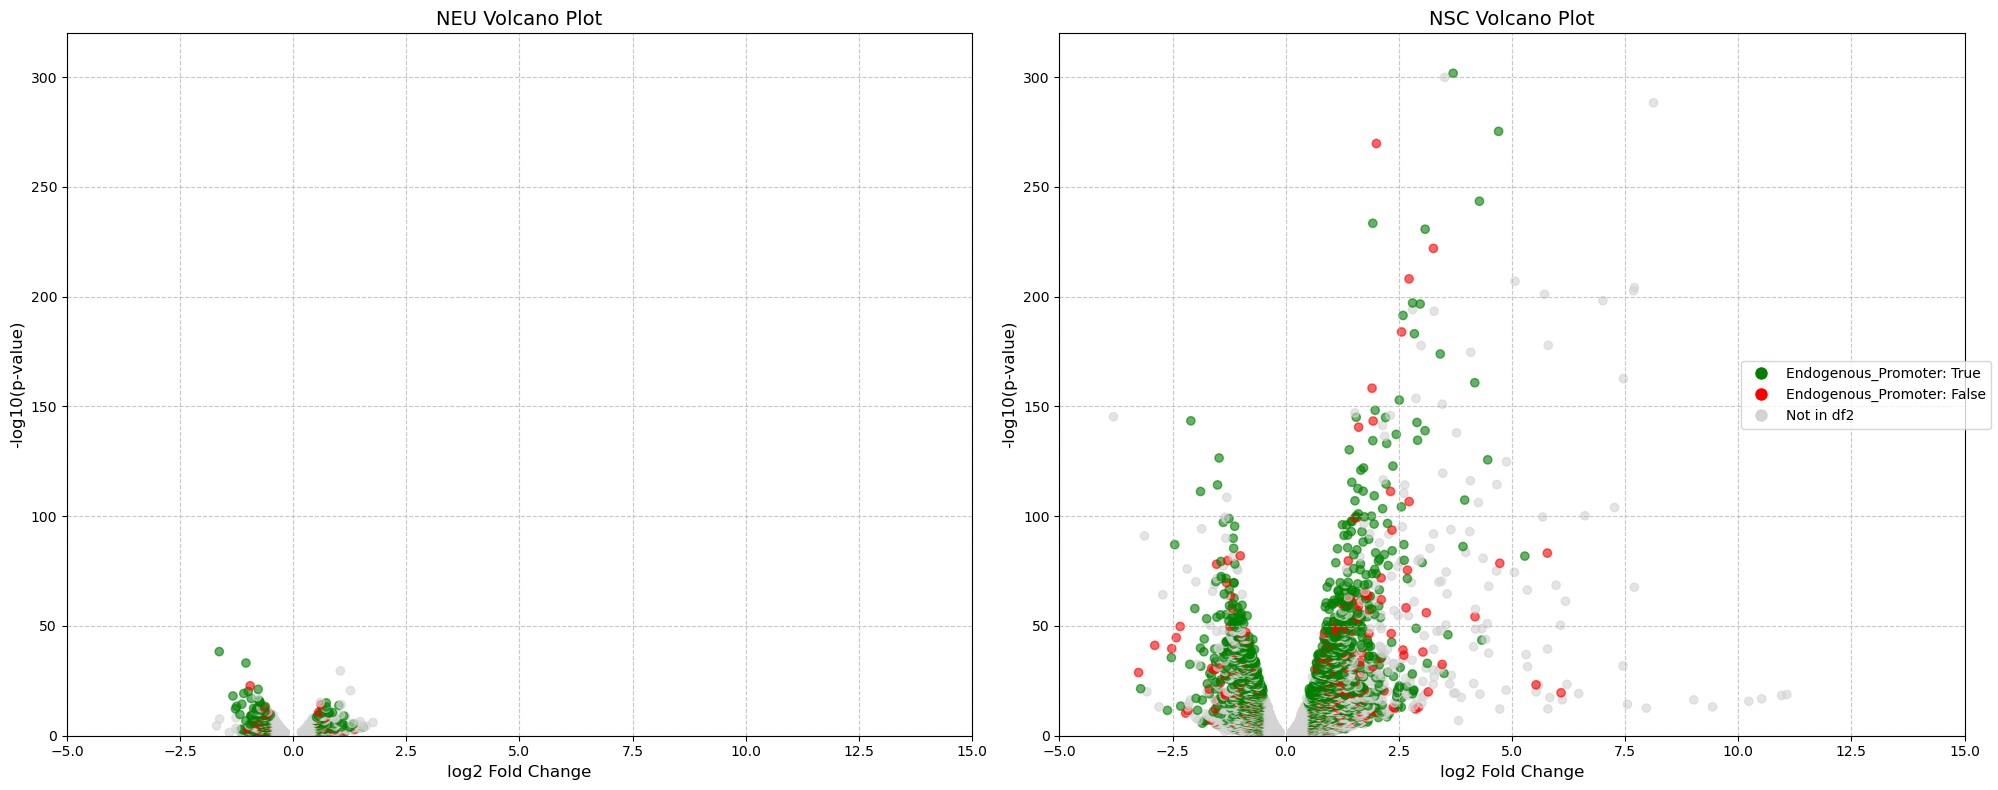

In [47]:
promoter_type='Endogenous_Promoter'

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Get data for both plots
colors1, x1, y1 = volcano_plot_mod(DEA_NEU, mecp2_NEU, promoter_type=promoter_type)
colors2, x2, y2 = volcano_plot_mod(DEA_NSC, mecp2_NSC, promoter_type=promoter_type)

# Find common axis limits
# x_min = min(x1.min(), x2.min())
# x_max = max(x1.max(), x2.max())
# y_min = min(y1.min(), y2.min())
# y_max = max(y1.max(), y2.max())

x_min = -5
x_max = 15
y_min = 0
y_max = 320

# Plot first volcano plot
ax1.scatter(x1, y1, c=colors1, alpha=0.6)
ax1.set_xlabel('log2 Fold Change', fontsize=12)
ax1.set_ylabel('-log10(p-value)', fontsize=12)
ax1.set_title('NEU Volcano Plot', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Add labels for first plot if needed
if True:  # For NEU plot
    pvalue_threshold = -np.log10(0.05)
    fc_threshold = 2
    for x, y, gene in zip(x1, y1, DEA_NEU['gene']):
        if (abs(x) > fc_threshold) and (y > pvalue_threshold):
            ax1.annotate(gene, (x, y), xytext=(5, 5), 
                        textcoords='offset points', fontsize=8)

# Plot second volcano plot
ax2.scatter(x2, y2, c=colors2, alpha=0.6)
ax2.set_xlabel('log2 Fold Change', fontsize=12)
ax2.set_ylabel('-log10(p-value)', fontsize=12)
ax2.set_title('NSC Volcano Plot', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Create custom legend (only need it once since it's the same for both)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='green', label=f'{promoter_type}: True', markersize=10),
                plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='red', label=f'{promoter_type}: False', markersize=10),
                plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='lightgrey', label='Not in df2', markersize=10)]

# Add legend to figure
fig.legend(handles=legend_elements, loc='center right')

plt.tight_layout()
plt.show()